# Aprendizado de Máquina - Projeto 1
### Guilherme Pereira Corrêa 198397
### Bruno Moreira 165295

## Parte 1 - Métodos de clusterização

## Coleta e tratamento dos dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import *
import string
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader
import random
from scipy.spatial import distance



C:\Users\guipe\AppData\Local\Programs\Python\Python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Tarefa 2D padrão:

Vamos primeiro visualizar os dados da tarefa 2D padrão e entender como os mesmos estão distribuídos.

[[1490.     27.55]
 [1445.     28.35]
 [1415.     28.8 ]
 ...
 [3525.     26.  ]
 [3570.     26.15]
 [3440.     25.6 ]]


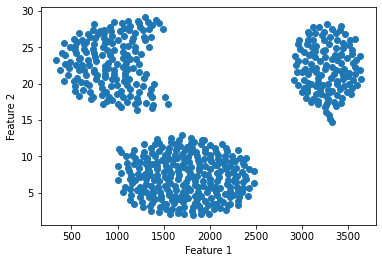

In [3]:
def scatter_data_2D(data):
    plt.scatter(data[:,0],data[:,1])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
def scatter_data_3D(data):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.scatter3D(data[:,0],data[:,1],data[:,2])

data = pd.read_csv('cluster.dat', delimiter=' ')
np_data = data.to_numpy()
print(np_data)
scatter_data_2D(np_data)

Percebe-se, então, que a feature 1 deste conjunto de dados tem uma escala muito maior que a feature 2 e, portanto, pode afetar os resultados por ter um peso maior indesejado nos cálculos de distância que serão realizados. Escalar estes dados pode resolver isso. Além disso, os dados estão distribuídos crescentemente e, portanto, devem ser embaralhados na separação entre train set e test set para evitar bias.

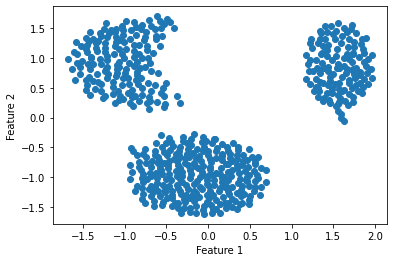

In [112]:
#normalizado com StandardScaler()
data_scaled = StandardScaler().fit_transform(np_data)
#normalizado com normalize
data_normalized = normalize(np_data,axis=0)
scatter_data_2D(data_scaled)

Agora vamos definir uma função para separar o dataset em training set e test set.

In [5]:
def split_dataset(data,train_proportion,test_proportion):
    set_size = data.shape[0]
    train_size = int(set_size*train_proportion)
    train_set = data[:train_size]
    test_set = data[train_size:]
    return train_set,test_set

In [115]:
#Dados sem pré processamento
np.random.shuffle(np_data)
train_set,test_set = split_dataset(np_data,0.9,0.1)

#Dados normalizados com StandardScaler
np.random.shuffle(data_scaled)
train_set_scaled,test_set_scaled = split_dataset(data_scaled,0.9,0.1)

#Dados normalizados com normalize
np.random.shuffle(data_normalized)
train_set_normalized,test_set_normalized = split_dataset(data_normalized,0.9,0.1)

### 2º conjunto de dados: tweets.
Foram escolhidos tweets para serem estudados como eles se comportam ao aplicar um algoritmo de clusterização. Porém, por se tratarem de textos, a forma como os mesmos são transformados em vetores de números (embedding) é crucial para o resultado. Neste projeto, esse processo foi dividido em três passos, onde existem diversas maneiras diferentes de se fazer cada um:

1 - Coleta e pré processamento dos tweets.

2 - Word embedding

3 - Document embedding

**1 - Coleta e pré processamento dos tweets**

O download dos tweets foi feito utilizando a biblioteca nltk, contendo 10000 tweets e uma anotação sobre o sentimento de cada um. Essa anotação é feita ao separar os mesmos em dois conjuntos, um para os tweets positivos e o outro para os tweets negativos, ou seja, como essa anotação não será utilizada neste trabalho, então esses dois conjuntos foram simplesmente concatenados um ao outro e então essa lista foi embaralhada a fim de evitar bias no momento de separar entre train set e test set.

O pré processamento de cada tweet foi feito ao remover stopwords, pontuação, links e hashtags, além de tokenização. Não foi feito stemming pois o modelo de embeddings utilizado considera as palavras completas e não suas raizes.

In [52]:
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):
            # remove punctuation
             tweets_clean.append(word)
            #stem_word = stemmer.stem(word)  # stemming word
            #tweets_clean.append(stem_word)
    return tweets_clean

def process_tweet_stem(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):
            # remove punctuation
             #tweets_clean.append(word)
             stem_word = stemmer.stem(word)  # stemming word
             tweets_clean.append(stem_word)
    return tweets_clean

In [8]:
nltk.download('twitter_samples')
nltk.download('stopwords')
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
all_tweets = all_positive_tweets + all_negative_tweets
#Shuffle para não ter bias na hora de separar entre train_set e test_set
np.random.shuffle(all_tweets)
#Cria um dicionário que mapeia cada index à um tweet para consulta futura
tweet2index_dic = {}
for i,tweet in enumerate(all_tweets):
    tweet2index_dic[tweet] = i
print(tweet2index_dic[:10])

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\guipe\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**2 - Word embedding**

Utilizando a biblioteca gensim, foi feito o download do modelo GloVe de 200 dimensões pré treinado no Twitter, essa escolha foi feita pois esse modelo é um dos que apresentam melhores resultados atualmente e, principalmente, porque ele foi treinado no Twitter, e o contexto de treino é muito importante neste tipo de tarefa.

In [9]:
#Treina um modelo de embedding baseado no corpus existente, mas achamos mais conveniente usar um modelo pronto
#embedding_model = Word2Vec(tweets_processed,vector_size=300,min_count=1)

In [88]:
#Embedding GloVe que será utilizado
glove_vectors = gensim.downloader.load('glove-twitter-200')

[-1.2304   0.48312  0.14102 -0.0295  -0.65253 -0.18554  2.1033   1.7516
 -1.3001  -0.32113 -0.84774  0.41995 -3.8823   0.19638 -0.72865 -0.85273
  0.23174 -1.0763  -0.83023  0.10815 -0.51015  0.27691 -1.1895   0.98094
 -0.13955]
[-1.2834    0.83066  -0.14512  -0.014446 -1.1355   -0.27814   0.35195
 -0.10683  -0.8272   -1.0412   -0.47496   0.73695  -1.1018    0.67362
 -0.6006   -0.28488   0.38399   0.16062   0.46243  -0.34206  -0.19761
  0.47318  -0.21806   0.55318  -0.42321 ]


**3 - Document embedding**

Há diversas maneiras de representar um tweet numericamente, mas muitas são custosas e, por conta disso, utilizamos uma ténica chamada Bag-of-words (BOW), onde a representação de um documento é dada pela soma das representações de cada palavra que o compõe.

In [122]:
def get_tweet_embedding(tweet, embedding_model,dimension):
    tweet_embedding = np.zeros(dimension)
    processed_tweet = process_tweet_stem(tweet)
    for word in processed_tweet:
        if embedding_model.get_index(word,False):
            tweet_embedding += embedding_model.get_vector(word,norm=0)
    return tweet_embedding


In [123]:
tweets_embedded = [get_tweet_embedding(tweet,glove_vectors,200) for tweet in all_tweets]

Resta, então, separar entre conjunto de treino e teste.

In [124]:
#Transforma para numpy array
tweets_embedded_np = np.array(tweets_embedded)
#Dados sem nenhuma normalização ou pré processamento desse tipo
tweets_train_set,tweets_test_set = split_dataset(tweets_embedded_np,0.9,0.1)

In [125]:
#Dados normalizados com StandardScaler()
tweets_embedded_np_scaled = StandardScaler().fit_transform(tweets_embedded_np)
tweets_train_set_scaled,tweets_test_set_scaled = split_dataset(tweets_embedded_np_scaled,0.9,0.1)

In [126]:
#Dados normalizados com normalize
tweets_embedded_np_normalized = normalize(tweets_embedded_np, axis = 0)
tweets_train_set_normalized,tweets_test_set_normalized = split_dataset(tweets_embedded_np_normalized,0.9,0.1)

### k-means

Classes e funções implementadas para aplicar o k-means:

In [127]:
class Point:
    def __init__(self, dimensions, point_index, cluster_index):
        self.dimensions = dimensions
        self.point_index = point_index
        self.cluster_index = cluster_index
        self.distance_to_center = -1

class Cluster:
    def __init__(self, dimensions):
        self.dimensions = dimensions
        self.points = []

def k_means(data, k):
    clusters = forgy_cluster_initialization(k, data)
    redefined = 1
    while redefined == 1:
        for point in data:
            for i in range(len(clusters)):
                if (point.cluster_index == -1):
                    point.cluster_index = i
                cluster_from_current_point = clusters[point.cluster_index]
                if (distance.euclidean(point.dimensions, clusters[i].dimensions) < distance.euclidean(point.dimensions, cluster_from_current_point.dimensions)):
                    point.cluster_index = i
                    point.distance_to_center = distance.euclidean(point.dimensions, clusters[i].dimensions)
            clusters[point.cluster_index].points.append(point)
        redefined = redefine_clusters_center(clusters)
    return clusters
    
def random_initialization(k, data):
    data_points = []
    for point in data:
        data_points.append(point.dimensions)

    max_value = np.max(np.array(data_points)[:,0])
    d = len(point.dimensions)
    clusters = []
    for _ in range(k):
        clusters.append(Cluster([random.uniform(0, max_value)] * d))
    return clusters

def forgy_cluster_initialization(k, data):
    clusters = []
    for _ in range(k):
        random_index = random.randint(0, len(data))
        clusters.append(Cluster(data[random_index].dimensions))
    return clusters
def redefine_clusters_center(clusters):
    redefined = 0
    for cluster in clusters:
        if (len(cluster.points) == 0):
            continue

        d = len(cluster.dimensions)
        sums = [0] * d

        for point in cluster.points:
            for i in range(d):
                sums[i] += point.dimensions[i]

        means = [0] * d
        n = len(cluster.points)
        for i in range(d):
            means[i] = round(sums[i]/n, 300)
            if (means[i] != cluster.dimensions[i]):
                cluster.dimensions[i] = means[i]
                redefined = 1
        if (redefined == 1):
            cluster.points.clear()
    return redefined

def plot_2d_data(clusters):
    colors = ["green","blue","yellow","pink","orange","purple","beige","brown","gray","cyan","magenta", "black"]
    for cluster in clusters:
        plt.plot(cluster.dimensions[0], cluster.dimensions[1], color = 'red', marker = 'o')
        for point in cluster.points:
            plt.scatter(point.dimensions[0], point.dimensions[1], color = colors[point.cluster_index], alpha = 0.5)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

def elbow_method(min_k, max_k):
    return

def silhouette_analysis():
    return

def cost_evaluation(clusters):
    j = 0
    for cluster in clusters:
        for point in cluster.points:
            j += pow(point.distance_to_center, 2)
    return j
def print_tweets_clusters(clusters, all_tweets_table):
    for i in range(len(clusters)):
        print('Cluster número ', i)
        for j in range(10):
            print(all_tweets_table[clusters[i].points[j].point_index])
        print('--------próximo cluster----------')
    

**Tarefa 2D padrão:**

Será feito o teste com os dados normalizados com a função normalize do sklearn, StandardScaler e sem realizar nenhum ajuste.

195043160.1959435


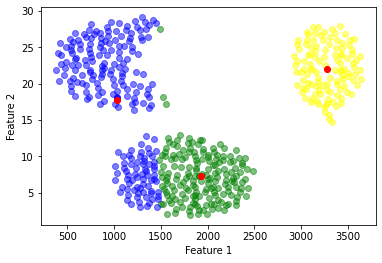

In [128]:
#Aplicar nos sets de treino
#Dados sem pré processamento:
points = []
for i in range(len(train_set)):
    points.append(Point(train_set[i], i, -1))
numero_de_clusters = 3
clusters = k_means(points, numero_de_clusters)
cost = cost_evaluation(clusters)
print(cost)
plot_2d_data(clusters)

802.2504000067348


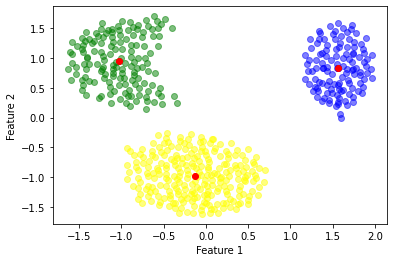

In [129]:
#Dados normalizados com StandardScaler
points = []
for i in range(len(train_set_scaled)):
    points.append(Point(train_set_scaled[i],i, -1))
numero_de_clusters = 3
clusters = k_means(points, numero_de_clusters)
cost = cost_evaluation(clusters)
print(cost)
plot_2d_data(clusters)

152.07332213984733


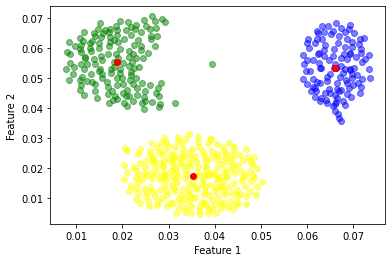

In [130]:
#Dados normalizador com normalize
points = []
for i in range(len(train_set_normalized)):
    points.append(Point(train_set_normalized[i],i, -1))
numero_de_clusters = 3
clusters = k_means(points, numero_de_clusters)
cost = cost_evaluation(clusters)
print(cost)
plot_2d_data(clusters)

Percebe-se então que os dois métodos de normalização fizeram com que o resultado fosse o esperado, enquanto que a técnica aplicada nos dados sem processamento gerou clusters longe do esperado e um custo muito alto. Além disso, percebe-se também que o custo utilizando a função normalize foi menor.

**2º conjunto de dados: tweets.**

Será feito o teste com os dados normalizados com a função normalize do sklearn, StandardScaler e sem realizar nenhum ajuste.

In [143]:
#Dados sem pré processamento:
points = []
for i in range(len(tweets_train_set)):
    points.append(Point(tweets_train_set_scaled[i],i, -1))
numero_de_clusters = 2
clusters = k_means(points, numero_de_clusters)
cost = cost_evaluation(clusters)
print(cost)
print_tweets_clusters(clusters, all_tweets)

1025332.5208428848
Cluster número  0
I really miss you :(
bday in 6 days :D
Off to somewhere later :)))
I just woke up and I feel incredibly sick idk if it's cause I drank Starbucks at 11 o'clock last night or if it's a reaction to my meds :)
@gala_con Sry i have a question , where does the dresscode count , because i dont want to stand in front of closed doors and iam confused :(
#welcomeTweet @aazem27 Thanks for following me.. :-) via http://t.co/adB1usrDwV
@neomeruru because....your cup is empty? :D
@lazybull81 also come game with me :)
I just want to get paid already :(
@riprap1 We like you Michael :) Thanks for your kind words! Cheers, Em
--------próximo cluster----------
Cluster número  1
Spring Fiesta 2015 

Make Some Noise, Awuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu!!!!!!!!! Aich :)
They don’t love me,they know me when they need me… :(
Taking 190 at such a horrible timing :(
@zoomtv @kdruls @mishrasugandha is your channel's show #PlanetBollywoodNews 's full epi available onlin

In [146]:
#Usando StandardScaler:
points = []
for i in range(len(tweets_train_set_scaled)):
    points.append(Point(tweets_train_set_scaled[i],i, -1))
numero_de_clusters = 2
clusters = k_means(points, numero_de_clusters)
cost = cost_evaluation(clusters)
print(cost)
print_tweets_clusters(clusters, all_tweets)

3821457.619540347
Cluster número  0
bday in 6 days :D
Off to somewhere later :)))
@deeziyah no Dublin :(( I'm so sorry I know how it feels the same thing sorta happened to me
7th CinePambata Video Festival: Complete mechanics and official entry form may be downloaded from http://t.co/YaYzAbtHtX. Sali na! :D
@POTUS #fever finally caught up with me \o/ \o/ \o/ .. #GESKenya 
#ObamaInKenya #MagicalKenya :-)
#GreatKenya #AllGoodThingsKE
I love Joy :(
@RamaZafar hayeee :( hayeee :( patwari here mam but for IK's vision I would say nothing rather than a lil laugh
Nams is just enjoying man :(
@max_pen1 It has been fixed, thanks for your feedback :)
@ashleelynda yes let's do it :)
--------próximo cluster----------
Cluster número  1
I really miss you :(
Spring Fiesta 2015 

Make Some Noise, Awuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu!!!!!!!!! Aich :)
I just woke up and I feel incredibly sick idk if it's cause I drank Starbucks at 11 o'clock last night or if it's a reaction to my meds :)
@gala_con

In [149]:
#Usando normalize:
points = []
for i in range(len(tweets_train_set_normalized)):
    points.append(Point(tweets_train_set_normalized[i],i, -1))
numero_de_clusters = 2
clusters = k_means(points, numero_de_clusters)
cost = cost_evaluation(clusters)
print(cost)
print_tweets_clusters(clusters, all_tweets)

512.4753786808368
Cluster número  0
wish i was good at makeup, the only thing im good at is doing eyeliner :(((
@TheVampsBrad where were you standing? so cool!!!! :)
@TheStonePilot sorry :(
@UberUK all ice cream vans are busy in Bristol :(
@Jesutomisin I hear you guys want Arbeloa. :D
No one thank that they have me bc of 1D! :(  
I H A T E M E. Kbye
@HolmesdaleCC Brill let us know when will have camera ready :)
@JaHz73 Thanks for the share Ju :D
@kchipongian Yay! Thankyou be :* Bonding ulit soon!! :') :)
@davefspringbank thanks Dave lovely day thanks to lovely family and friends. How did I miss that! Congratulations :-)
--------próximo cluster----------
Cluster número  1
I really miss you :(
Spring Fiesta 2015 

Make Some Noise, Awuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu!!!!!!!!! Aich :)
bday in 6 days :D
Off to somewhere later :)))
I just woke up and I feel incredibly sick idk if it's cause I drank Starbucks at 11 o'clock last night or if it's a reaction to my meds :)
@gala_con Sry i

In [152]:
print_tweets_clusters(clusters, all_tweets)

Cluster número  0
wish i was good at makeup, the only thing im good at is doing eyeliner :(((
@TheVampsBrad where were you standing? so cool!!!! :)
@TheStonePilot sorry :(
@UberUK all ice cream vans are busy in Bristol :(
@Jesutomisin I hear you guys want Arbeloa. :D
No one thank that they have me bc of 1D! :(  
I H A T E M E. Kbye
@HolmesdaleCC Brill let us know when will have camera ready :)
@JaHz73 Thanks for the share Ju :D
@kchipongian Yay! Thankyou be :* Bonding ulit soon!! :') :)
@davefspringbank thanks Dave lovely day thanks to lovely family and friends. How did I miss that! Congratulations :-)
--------próximo cluster----------
Cluster número  1
I really miss you :(
Spring Fiesta 2015 

Make Some Noise, Awuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu!!!!!!!!! Aich :)
bday in 6 days :D
Off to somewhere later :)))
I just woke up and I feel incredibly sick idk if it's cause I drank Starbucks at 11 o'clock last night or if it's a reaction to my meds :)
@gala_con Sry i have a question ,

In [155]:
tweets_processed = [process_tweet_stem(tweet) for tweet in all_tweets]
embedding_model_2 = Word2Vec(tweets_processed,vector_size=300,min_count=1)

In [157]:
def get_tweet_embedding_2(tweet, embedding_model,dimension):
    #This version doesn't do the process step
    word_vectors = embedding_model.wv
    tweet_embedding = np.zeros(dimension)
    for word in tweet:
        if word_vectors.get_index(word,False):
            tweet_embedding += word_vectors.get_vector(word,norm=0)
    return tweet_embedding

In [159]:
tweets_embedded_2 = [get_tweet_embedding_2(tweet,embedding_model_2,300) for tweet in tweets_processed]
tweets_embedded_np_2 = np.array(tweets_embedded_2)
tweets_embedded_np_scaled_2 = StandardScaler().fit_transform(tweets_embedded_np_2)
tweets_embedded_np_normalized_2 = normalize(tweets_embedded_np_2, axis =0)
tweets_train_set_scaled_2,tweets_own_test_set_scaled_2 = split_dataset(tweets_embedded_np_scaled_2,0.9,0.1)

In [160]:
#Aplicar k-means neste novo conjunto de dados de tweets
points = []
for i in range(len(tweets_train_set_scaled_2)):
    points.append(Point(tweets_train_set_scaled_2[i],i, -1))
numero_de_clusters = 2
clusters_2 = k_means(points, numero_de_clusters)
cost = cost_evaluation(clusters_2)
print(cost)
print_tweets_clusters(clusters_2, all_tweets)

1529827.9158113792
Cluster número  0
Spring Fiesta 2015 

Make Some Noise, Awuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu!!!!!!!!! Aich :)
bday in 6 days :D
I just woke up and I feel incredibly sick idk if it's cause I drank Starbucks at 11 o'clock last night or if it's a reaction to my meds :)
@gala_con Sry i have a question , where does the dresscode count , because i dont want to stand in front of closed doors and iam confused :(
They don’t love me,they know me when they need me… :(
@neomeruru because....your cup is empty? :D
Taking 190 at such a horrible timing :(
I just want to get paid already :(
@riprap1 We like you Michael :) Thanks for your kind words! Cheers, Em
this new Sandra Bland footage is really the icing on the cake.. heartbreaking how they dragged her lifeless body from the police car :(
--------próximo cluster----------
Cluster número  1
I really miss you :(
Off to somewhere later :)))
#welcomeTweet @aazem27 Thanks for following me.. :-) via http://t.co/adB1usrDwV
@lazy

In [161]:
print(tweets_own_embedded[0])
#Aplicar k means nesse, vai primeiro precisar normalizar e tals

[ 0.87750059 -1.03566527  1.17040622 -2.160164   -1.01173753 -1.47733372
  1.27690834  3.79860342 -3.27273309 -2.61418748  1.29984558  0.19667664
  2.02696133  1.67618996 -2.14929479  1.06926924  1.5631609  -0.29477904
 -1.93194294  0.96696615  1.12085748  1.39174122  2.75556898  1.2121346
  2.99140286]


### Outro método


In [162]:
#Aplicar nos sets de treino
#Dados 2D:
train_set,test_set

#Dados twitter:
tweets_train_set_scaled,tweets_test_set_scaled

(array([[ 1.06799497, -0.31803297, -0.19174008, ..., -0.21496865,
         -0.653688  , -0.79944787],
        [ 1.29477459,  0.41284423, -0.35393663, ...,  0.29532885,
          0.41601344,  0.11011099],
        [ 2.3450443 ,  0.89939858, -2.87855484, ..., -2.1385719 ,
          2.00074023,  0.02465534],
        ...,
        [ 0.95815275, -0.37830373,  0.41412942, ...,  0.02737131,
         -0.38053173, -0.64358251],
        [-0.4291784 ,  0.53161729, -0.44819259, ...,  1.5603015 ,
          0.19919622, -1.00253242],
        [-0.06094885, -0.07217922, -0.44436163, ..., -0.18471308,
         -0.10496349, -0.06912541]]),
 array([[-0.58873324,  1.85550974,  1.04409557, ...,  1.11258482,
          0.20764305, -0.16547386],
        [ 1.14149291,  1.43920362, -1.49063947, ..., -0.66179565,
          0.48162365, -0.27825848],
        [-0.51246608,  0.15753241, -0.94190518, ..., -0.27558176,
          0.02770248, -0.42143838],
        ...,
        [-0.65541155,  0.42387547,  0.59623089, ...,  

## Parte 2 - Redução de dimensionalidade

A biblioteca scikit lean foi utilizada para aplicar PCA aos dados.

Dimensionalidade reduzida, proporção de variância em cada componente é:
[0.66767395 0.31921435]


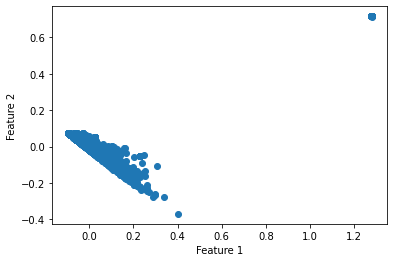

Dimensionalidade reduzida, proporção de variância em cada componente é:
[0.66767395 0.31921435 0.00796876]


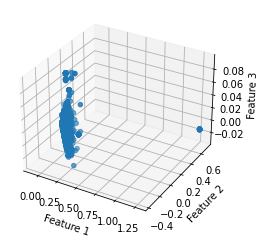

In [163]:
from sklearn.decomposition import PCA
def red_dim(data,n_comp):
    pca = PCA(n_components=n_comp)
    pca.fit(data)
    new_data = pca.transform(data)
    print("Dimensionalidade reduzida, proporção de variância em cada componente é:")
    print(pca.explained_variance_ratio_)
    return new_data

#
tweets_new_2D = red_dim(tweets_embedded_np_normalized_2,2)
scatter_data_2D(tweets_new_2D)
tweets_new_3D = red_dim(tweets_embedded_np_normalized_2,3)
scatter_data_3D(tweets_new_3D)

In [164]:
# k means nos tweets em 2D


Percebe-se então